# Import library and load data

In [1]:
import os
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

plt.rcParams['figure.figsize'] = [8,5]
torch.manual_seed(0)

In [2]:
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

==> Preparing data..


100%|██████████| 170M/170M [00:51<00:00, 3.30MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
# TEST DIMENSION - DONE
batch = next(iter(trainloader))
images, labels = batch
print ("Shape of one batch in the Dataloader")
print (f"Inputs: {images.shape}; Labels: {labels.shape}")

Shape of one batch in the Dataloader
Inputs: torch.Size([128, 3, 32, 32]); Labels: torch.Size([128])


# Define model

In [4]:
class IdentityBlock(nn.Module):
    def __init__(self, f, filters):
        super(IdentityBlock, self).__init__()
        F0,F1,F2,F3 = filters
        
        self.conv1 = nn.Conv2d(in_channels=F0, out_channels=F1, kernel_size=1, stride=1, padding=0)
        self.bn1   = nn.BatchNorm2d(F1)
        self.conv2 = nn.Conv2d(in_channels=F1, out_channels=F2, kernel_size=f, stride=1, padding='same')
        self.bn2   = nn.BatchNorm2d(F2)
        self.conv3 = nn.Conv2d(in_channels=F2, out_channels=F3, kernel_size=1, stride=1, padding=0)
        self.bn3   = nn.BatchNorm2d(F3)
        
    def forward(self, x):
        x_shortcut = x
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.relu(x+x_shortcut)
        
        return x

In [5]:
class ConvolutionalBlock(nn.Module):
    def __init__(self, f, s, filters):
        super(ConvolutionalBlock, self).__init__()
        F0,F1,F2,F3 = filters
        
        self.conv1 = nn.Conv2d(in_channels=F0, out_channels=F1, kernel_size=1, stride=s, padding=0)
        self.bn1   = nn.BatchNorm2d(F1)
        self.conv2 = nn.Conv2d(in_channels=F1, out_channels=F2, kernel_size=f, stride=1, padding='same')
        self.bn2   = nn.BatchNorm2d(F2)
        self.conv3 = nn.Conv2d(in_channels=F2, out_channels=F3, kernel_size=1, stride=1, padding=0)
        self.bn3   = nn.BatchNorm2d(F3)
        
        self.shortcut_conv = nn.Conv2d(in_channels=F0, out_channels=F3, kernel_size=1, stride=s, padding=0)
        self.shortcut_bn  = nn.BatchNorm2d(F3)
        
    def forward(self, x):
        x_shortcut = x
        x_shortcut = self.shortcut_bn(self.shortcut_conv(x_shortcut))

        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))

        x = torch.relu(x + x_shortcut)

        return x

In [6]:
class ResNet50(nn.Module):
    def __init__(self):
        super(ResNet50, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1   = nn.BatchNorm2d(64)

        self.conv_block2 = ConvolutionalBlock(3,1, (64,64,64,256))
        self.id_block2   = IdentityBlock(3, (256,64,64,256))

        self.conv_block3 = ConvolutionalBlock(3,2, (256,128,128,512))
        self.id_block3   = IdentityBlock(3, (512,128,128,512))

        self.conv_block4 = ConvolutionalBlock(3,2, (512,256,256,1024))
        self.id_block4   = IdentityBlock(3, (1024,256,256,1024))

        self.conv_block5 = ConvolutionalBlock(3,2, (1024,512,512,2048))
        self.id_block5   = IdentityBlock(3, (2048,512,512,2048))

        self.avg_pooling = nn.AvgPool2d(kernel_size = (4,4))
        self.linear      = nn.Linear(2048,10)
        
        
    def forward(self, x):
        # Stage 1
        x = torch.relu(self.bn1(self.conv1(x)))

        # Stage 2
        x = self.id_block2(self.id_block2(self.conv_block2(x)))

        # Stage 3
        x = self.id_block3(self.id_block3(self.id_block3(self.conv_block3(x))))

        # Stage 4
        x = self.id_block4(self.id_block4(self.id_block4(self.id_block4(self.id_block4(self.conv_block4(x))))))

        # Stage 5
        x = self.id_block5(self.id_block5(self.conv_block5(x)))

        # Stage 6
        x = self.avg_pooling(x)
        x = x.reshape(x.shape[0],-1)
        x = self.linear(x)

        return x


In [8]:
def evaluate(model, testloader, criterion, device):
    batch_count = len(testloader)
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []
    model.eval()

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    if total == 0:
        print("No valid batches found during evaluation")
        return None
        
    accuracy = 100 * correct / total
    test_loss = test_loss/batch_count
        
    return accuracy, test_loss

In [10]:
def train(model, trainloader, criterion, optimizer, epochs, device):
    batch_count = len(trainloader)
    train_losses = []
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        running_loss = running_loss/batch_count
        train_losses.append(running_loss)
        accuracy, test_loss = evaluate(model, testloader, criterion, device)
        
        print(f"Epoch {epoch}: Train loss = {running_loss:.4f}, Test loss = {test_loss:.4f}")
        print(f"Accuracy on test set: {accuracy:5.2f}%")

        # Lưu mô hình nếu đạt độ chính xác cao nhất
        if accuracy > best_acc:
            best_acc = accuracy
            os.makedirs('models', exist_ok=True)  # Create folder if not exist
            torch.save(model.state_dict(), 'models/best_model.pth')
            print(f"Model saved as 'best_model.pth' with accuracy: {best_acc:.3f}%")
    
        print("-"*64)

    return train_losses

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Train
model = ResNet50().to(device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
train_losses = train(model, trainloader, criterion, optimizer, epochs=100, device=device)

cuda
Epoch 0: Train loss = 1.6210, Test loss = 1.4554
Accuracy on test set: 47.98%
Model saved as 'best_model.pth' with accuracy: 47.980%
----------------------------------------------------------------
Epoch 1: Train loss = 1.1372, Test loss = 1.0649
Accuracy on test set: 61.25%
Model saved as 'best_model.pth' with accuracy: 61.250%
----------------------------------------------------------------
Epoch 2: Train loss = 0.9067, Test loss = 0.9789
Accuracy on test set: 65.98%
Model saved as 'best_model.pth' with accuracy: 65.980%
----------------------------------------------------------------
Epoch 3: Train loss = 0.7773, Test loss = 0.8377
Accuracy on test set: 70.58%
Model saved as 'best_model.pth' with accuracy: 70.580%
----------------------------------------------------------------
Epoch 4: Train loss = 0.6888, Test loss = 0.7515
Accuracy on test set: 74.24%
Model saved as 'best_model.pth' with accuracy: 74.240%
----------------------------------------------------------------
Epoch

In [14]:
# Load model
model.load_state_dict(torch.load("models/best_model.pth", weights_only=True))
model.to(device)
model.eval()
accuracy, test_loss = evaluate(model, testloader, criterion, device)
print(f'Accuracy on test set: {accuracy:.2f}%')

Accuracy on test set: 91.08%


# Plot loss history

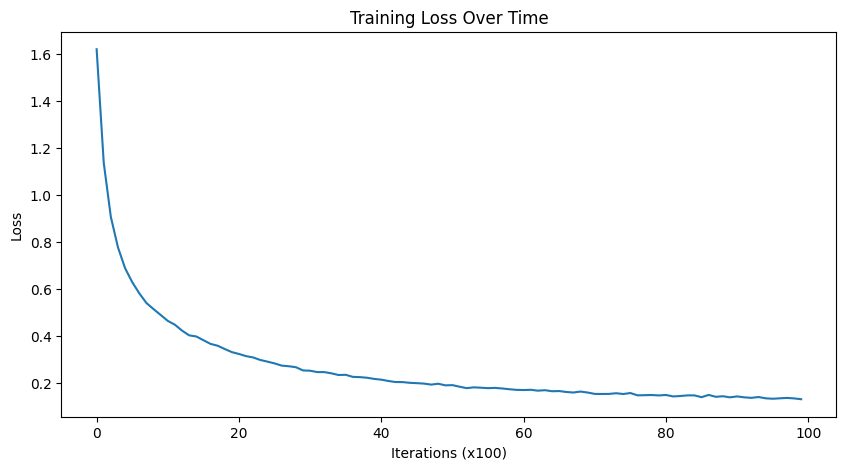

In [13]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses)
plt.title('Training Loss Over Time')
plt.xlabel('Iterations (x100)')
plt.ylabel('Loss')
plt.show()